In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce


from bold_dementia.cogpred import make_training_data, make_all_data, extract_net, MockAtlas
from bold_dementia.utils.configuration import get_config

from neuroginius.atlas import Atlas
from bold_dementia.cogpred import plot_matrix, MatrixResult

config = get_config()
gsr = 'true'
atlas = Atlas.from_name("schaefer200")

if atlas.name == 'aal':
    atlas.networks = list(map(lambda x: str(x).split("_")[0], atlas.labels))

matrices, metadata = make_all_data(
    config["connectivity_matrices"],
    atlas.name,
    k=3,
    suffix=f"kind-corr_gsr-{gsr}"
)
sns.reset_defaults()

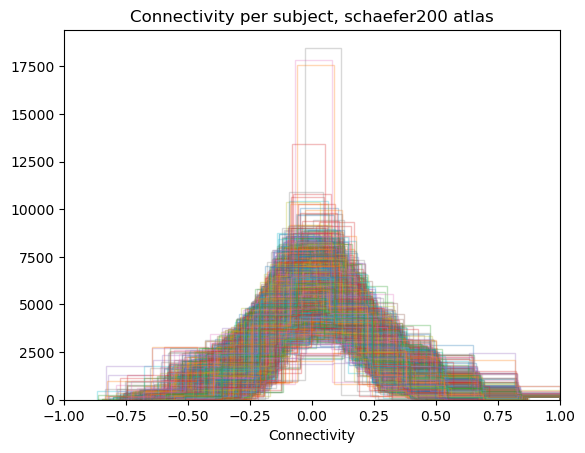

In [17]:
idx= np.tril_indices_from(matrices[0])
for mat in matrices:
    plt.hist(mat[idx], histtype="step", alpha=0.3)
plt.title(f"Connectivity per subject, {atlas.name} atlas")
plt.xlabel("Connectivity")
plt.xlim(-1, 1)
plt.show()

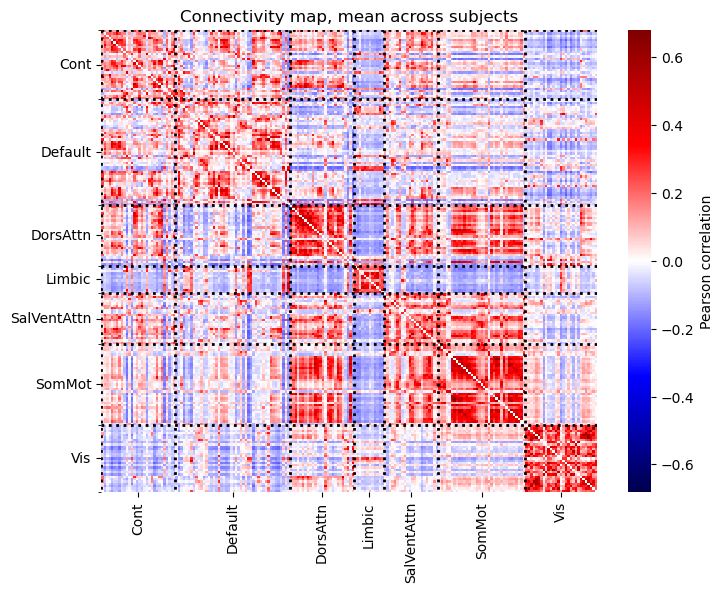

In [18]:
plot_matrix(np.mean(matrices, axis=0), atlas, cmap="seismic", cbar_kws=dict(label="Pearson correlation"))
plt.title("Connectivity map, mean across subjects")
plt.show()

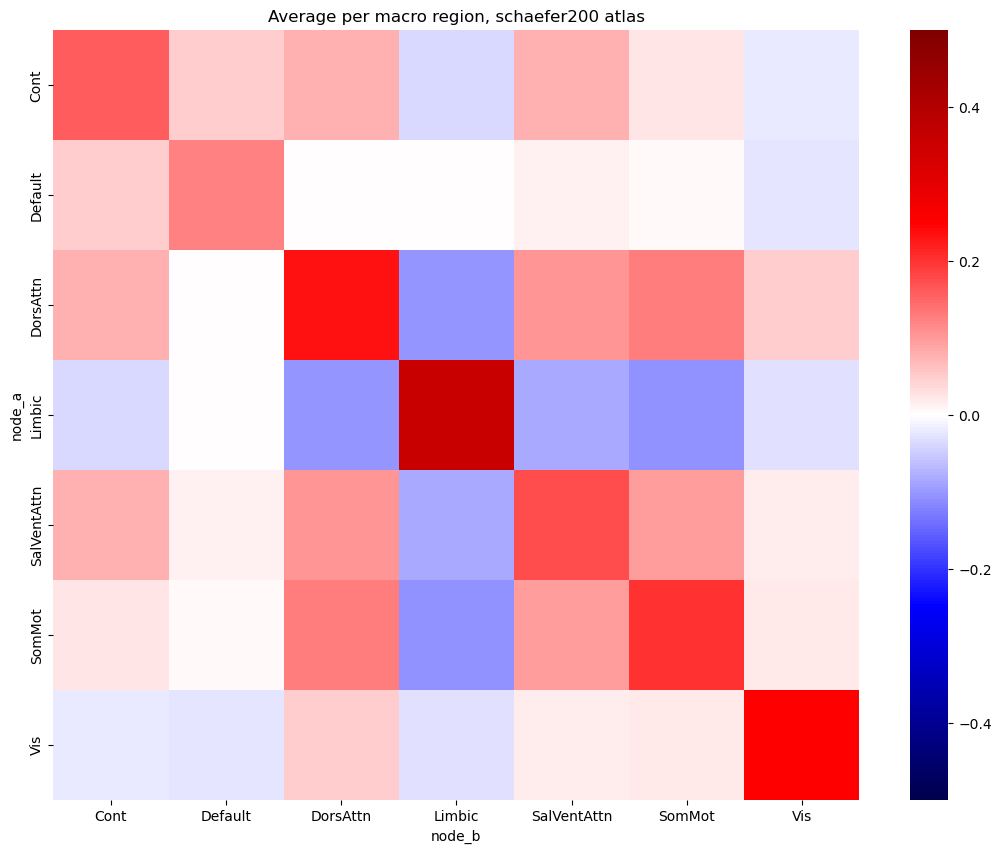

In [19]:
mr = MatrixResult(matrices, atlas)
macro_matrix = reduce(lambda x, y: x.add(y) / 2, mr.get_macro_matrices())
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(macro_matrix, cmap="seismic", vmin=-0.5, vmax=0.5, ax=ax)
plt.title(f"Average per macro region, {atlas.name} atlas")
plt.show()

In [20]:
comp_lst = []

matrix_res = MatrixResult(matrices, atlas)
for i, sorted_mat in enumerate(matrix_res.sorted_matrices):
    gen = matrix_res._gen_upper_triangular(sorted_mat, lambda x: (x.mean(),))
    comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "connectivity"])
    comparisons["sub"] = metadata.loc[i, "sub"]
    comparisons["ses"] = metadata.loc[i, "ses"]
    comp_lst.append(comparisons)


In [21]:
pd.concat(comp_lst).to_csv(f"output/connectivity_export_uniquevals/{atlas.name}_all_gsr-{gsr}.csv")